# Analysis of NIHS data with DeepMapper 

This notebook runs DeepMapper with the proof of concept data that has the NIHS data generated by NIHS notebook

## Import Libraries


In [1]:

from pyDeepMapper import DeepMapper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, scale, minmax_scale
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import warnings; 
warnings.simplefilter('ignore')

In [2]:
import random
seed=12345
random.seed(seed)

In [3]:
datafilename = 'pocdata-fin.pickle'


In [4]:
import pickle
with open('pocdata-fin.pickle', 'rb') as data_file:
    data = pickle.load(data_file)
    X=data['X']
    y=data['y'], 
    feature_names=data['feature_names']
    obs_names=data['obs_names']
    class_names=data['class_names']

In [5]:
class_names

['Class 1', 'Class 2']

In [6]:
y=y[0]
y

array([0, 0, 0, ..., 1, 1, 1])

In [7]:
X_norm = X
#X_norm = scale(X, axis=0, with_mean=True, with_std=True, copy=True)
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 1]), array([7500, 7500]))

In [8]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
print(y_enc)
num_classes = np.unique(y_enc).size
print(num_classes, class_names)

[0 0 0 ... 1 1 1]
2 ['Class 1', 'Class 2']


In [9]:
%%time
X_img = DeepMapper.map(X)

CPU times: user 637 ms, sys: 411 ms, total: 1.05 s
Wall time: 1.05 s


In [10]:
X_img.shape

(15000, 135, 135, 1)

In [11]:
class_names

['Class 1', 'Class 2']

The following are showing plots for the image matrices first four samples 
of the training set. 

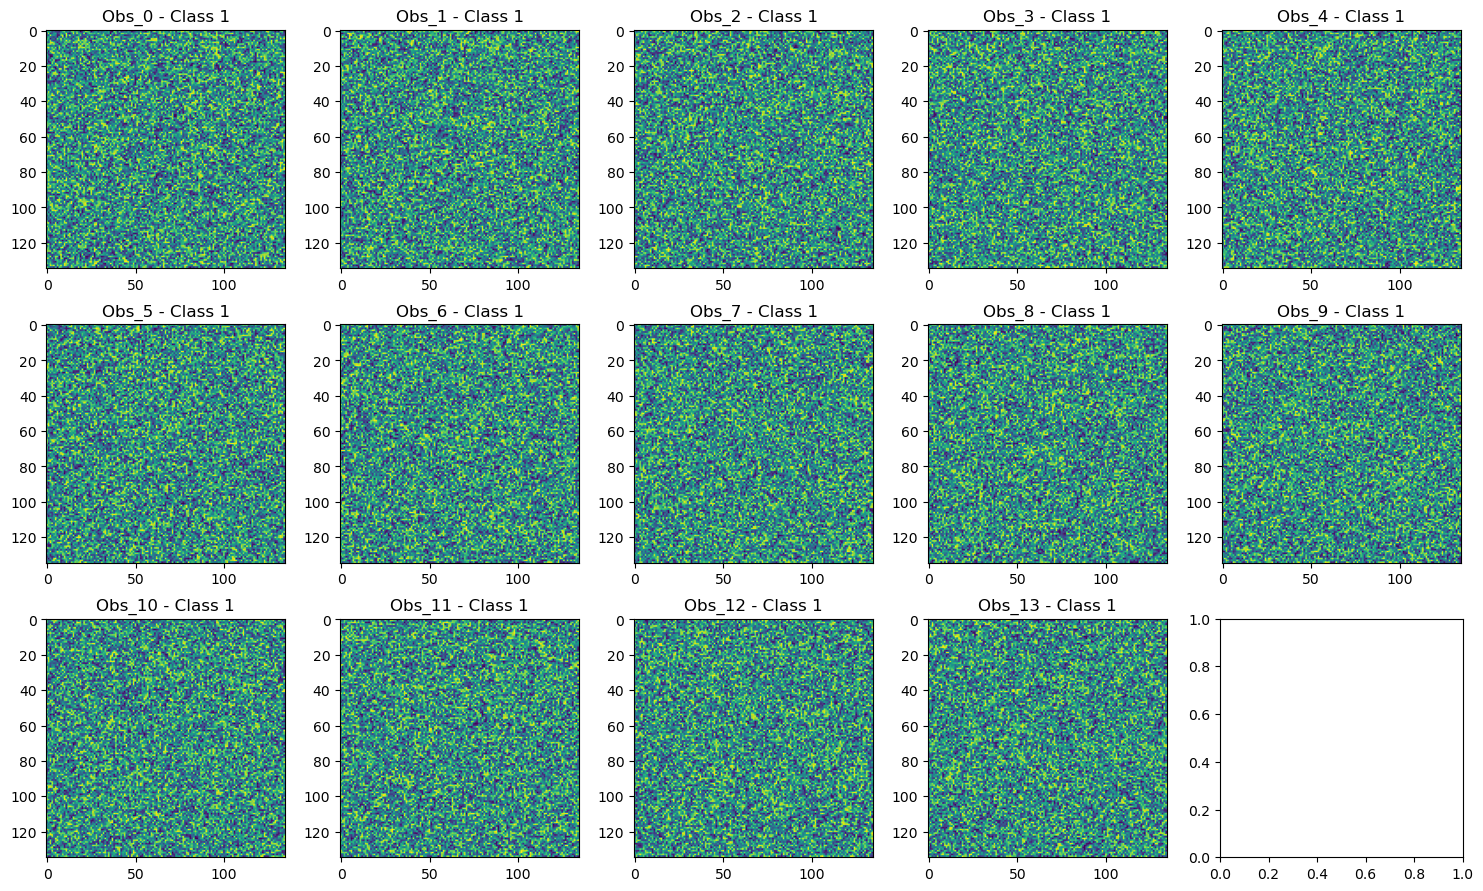

In [12]:
pics=14
num_images_per_row = 5
num_cols=pics // num_images_per_row + 1
fig, ax = plt.subplots(num_cols, num_images_per_row, figsize=(15, 3 * num_cols))
for i in range(0,pics):
    row= i // num_images_per_row
    col=i % num_images_per_row
    ax[row,col].imshow(X_img[i])
    ax[row,col].title.set_text(f"{obs_names[i]} - {class_names[y[i]]}")
plt.tight_layout()

Transforming the testing data is done the same as transforming the 
training data.

## Training

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Transform numpy image format to PyTorch tensor. 

In [14]:
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.expand(3, -1, -1))
])

def create_tensors_from(X,y):
    X_tensor = torch.stack([preprocess(elm) for elm in X]).float()
    y_tensor = torch.from_numpy(le.fit_transform(y))
    return(X_tensor, y_tensor)



Generate pyTorch datasets and dataloaders for training and testing sets.

In [15]:

def load_batch(dataset,  batch_size):
    return(DataLoader(dataset, batch_size=batch_size, shuffle=True))

Specify loss function and optimization algorithm

In [16]:
def set_model(num_classes,pretrained=False):
#    model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=pretrained)
    model = torchvision.models.resnet18(pretrained=pretrained)
    num_features = model.fc.in_features     #extract fc layers features
    model.fc = nn.Linear(num_features, num_classes)
    for param in model.fc.parameters():
        param.requires_grad = True
    return(model)

In [17]:
 def set_run_params(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=1e-03,
        #momentum=0.8,
        weight_decay=1e-05
    )
    return((criterion, optimizer))

##Train

In [18]:

def train(model,epochs,trainloader, testloader,criterion,optimizer,training_data_size, batch_size=100):
    model.train()
    model.to(device)
    for epoch in range(1,epochs+1):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        # print epoch statistics
#        if not (epoch % 10):
#            print(f'[{epoch}] loss: {running_loss / training_data_size * batch_size:.3f}')
    print(f'End training. Loss: {running_loss / training_data_size * batch_size:.3f}')
    return (outputs)


In [19]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True

In [20]:
from captum.attr import IntegratedGradients, Saliency, GradientShap, DeepLift, InputXGradient,LRP
import torch.nn.functional as F
def deepmap(X, y, num_epochs, num_passes, batch_size, max_vars, min_accuracy=0.79, max_tries=20):
    results=[]
    imps=[]
    passes=0
    tries=0
    prediction_score=[]
    X_tensor, y_tensor = create_tensors_from(X,y)
    for i in range(0,num_passes):
        tries = tries+1
        model=set_model(num_classes)
        criterion,optimizer=set_run_params(model)
        X_train_tensor,X_test_tensor,y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.25, shuffle=True)
        train_dataset = TensorDataset(X_train_tensor,y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor,y_test_tensor)
        trainloader = load_batch(train_dataset,  batch_size)
        testloader = load_batch(test_dataset,  batch_size)
        train(model,num_epochs,trainloader, testloader,criterion,optimizer, len(X_train_tensor),batch_size=batch_size)
        model.to('cpu')
        model = model.eval()
        with torch.no_grad():
            y_hat = model(X_train_tensor)
        train_predicted = torch.max(y_hat, 1)[1]
        with torch.no_grad():
            y_hat = model(X_test_tensor)
        test_predicted = torch.max(y_hat, 1)[1]
        train_accuracy = accuracy_score(train_predicted.cpu(), y_train_tensor)
        test_accuracy = accuracy_score(test_predicted, y_test_tensor)
        print(f"The train accuracy was {train_accuracy:.3f}")
        print(f"The test accuracy was {test_accuracy:.3f}")
        if test_accuracy >= min_accuracy:
            if not (passes % (num_passes // 5)):
                _ = ConfusionMatrixDisplay.from_predictions(test_predicted, y_test_tensor, display_labels=class_names)
            plt.show()
            set_parameter_requires_grad(model, True)
            model.cpu()
            output = model(X_test_tensor)
            output = F.softmax(output, dim=1)
            prediction_score, pred_label_idx = torch.topk(output, 1)
            pred_label_idx.squeeze_()
            #predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
            print(np.unique(pred_label_idx, return_counts=True))
            X_test_tensor.cpu()
            model.cpu()
            X_test_tensor.requires_grad_()
            ig = Saliency(model)
            attrs={}
            targets=np.unique(test_predicted.cpu().numpy()).tolist()
            print (targets)
            for target in targets:
                print('Target to be done:',target)
                attr = ig.attribute(X_test_tensor,target=target)#, return_convergence_delta=True)
                attr = attr.mean(axis=0).unsqueeze(0)
                attr = attr.detach()
                attrs[target]=attr
            results.append(attrs)
            attlists={}
            for key,attr in attrs.items():
                attlist=np.sum(np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)), axis=2).flatten()
                attindex=np.array(range(0,len(attlist)))
                attlists[key]=attlist
            names =  ['Var'+str(i) for i in range(0,len(y))]
            maxdet=max_vars
            imp={}
            for key,attlist in attlists.items():
                maxX=[]
                maxV=[]
                for i in range(0,maxdet):
                    idxmax=np.abs(attlist).argmax()
                    fn = 'none' if idxmax >= len(feature_names) else feature_names[idxmax]
#                    print(fn,idxmax, attlist[idxmax])
                    maxX.append(idxmax)
                    maxV.append(attlist[idxmax])
                    attlist[idxmax]=0
                imp[key]=(maxX,maxV)
            imps.append(imp)
            passes = passes+1
        else: 
            print ('Test accuracty is not satisfactory')
    return((model,results,imps, X_test_tensor, prediction_score))


End training. Loss: 0.033
The train accuracy was 0.994
The test accuracy was 0.903


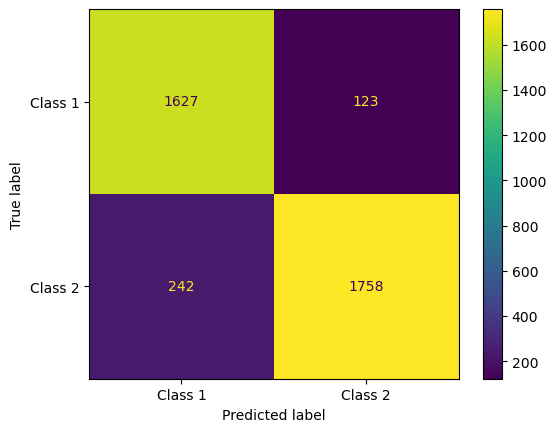

(array([0, 1]), array([1750, 2000]))
[0, 1]
Target to be done: 0
Target to be done: 1
End training. Loss: 0.037
The train accuracy was 0.997
The test accuracy was 0.918
(array([0, 1]), array([1778, 1972]))
[0, 1]
Target to be done: 0
Target to be done: 1
End training. Loss: 0.034
The train accuracy was 0.994
The test accuracy was 0.912


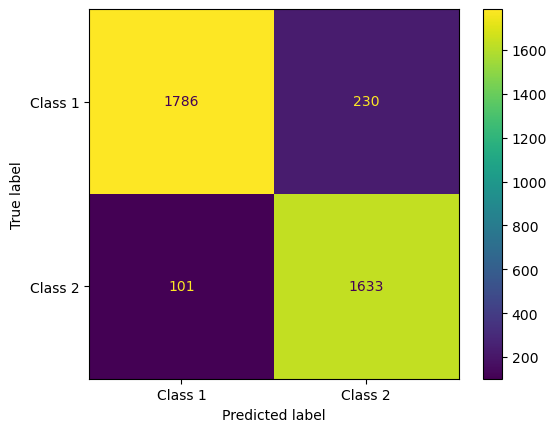

(array([0, 1]), array([2016, 1734]))
[0, 1]
Target to be done: 0
Target to be done: 1
End training. Loss: 0.029
The train accuracy was 0.974
The test accuracy was 0.889
(array([0, 1]), array([2126, 1624]))
[0, 1]
Target to be done: 0
Target to be done: 1
End training. Loss: 0.020
The train accuracy was 0.999
The test accuracy was 0.993


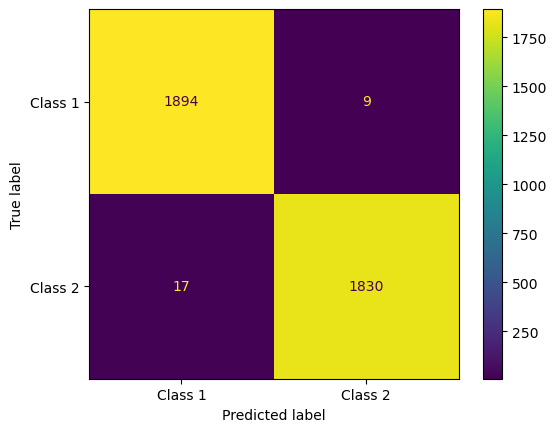

(array([0, 1]), array([1903, 1847]))
[0, 1]
Target to be done: 0
Target to be done: 1
End training. Loss: 0.012
The train accuracy was 0.995
The test accuracy was 0.982
(array([0, 1]), array([1787, 1963]))
[0, 1]
Target to be done: 0
Target to be done: 1
End training. Loss: 0.011
The train accuracy was 0.918
The test accuracy was 0.899


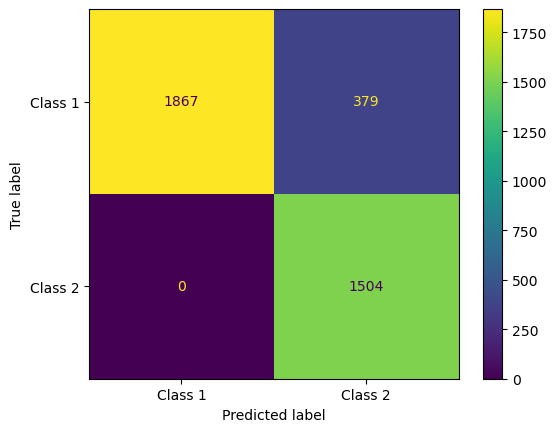

(array([0, 1]), array([2246, 1504]))
[0, 1]
Target to be done: 0
Target to be done: 1
End training. Loss: 0.032
The train accuracy was 0.995
The test accuracy was 0.913
(array([0, 1]), array([1861, 1889]))
[0, 1]
Target to be done: 0
Target to be done: 1
End training. Loss: 0.031
The train accuracy was 0.999
The test accuracy was 0.993


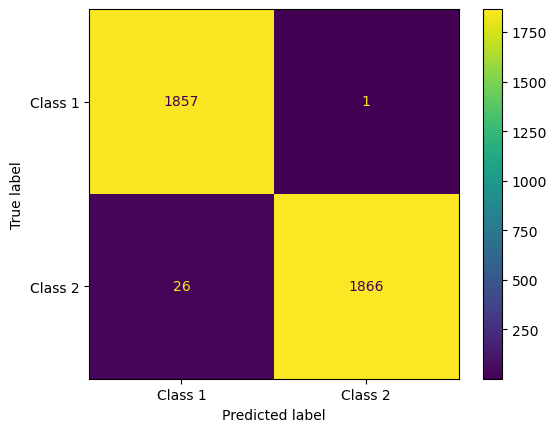

(array([0, 1]), array([1858, 1892]))
[0, 1]
Target to be done: 0
Target to be done: 1
End training. Loss: 0.024
The train accuracy was 0.992
The test accuracy was 0.957
(array([0, 1]), array([2020, 1730]))
[0, 1]
Target to be done: 0
Target to be done: 1


In [21]:
model,results,imps, test_input, test_=deepmap(X_img, y_enc, 15,10, 20, 20, min_accuracy= 0.8)

In [22]:
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
from importlib import reload

In [23]:
i=0
sums=[[]] * len(results[0])
for attrs in results:
    for key,att in attrs.items():
        arr=np.transpose(att.squeeze().cpu().detach().numpy(), (1,2,0))
        if sums[key]==[]:
            sums[key]=arr
        else:
            sums[key]=sums[key]+arr
        print(i,key,sums[key].shape)
        i=i+1

0 0 (135, 135, 3)
1 1 (135, 135, 3)
2 0 (135, 135, 3)
3 1 (135, 135, 3)
4 0 (135, 135, 3)
5 1 (135, 135, 3)
6 0 (135, 135, 3)
7 1 (135, 135, 3)
8 0 (135, 135, 3)
9 1 (135, 135, 3)
10 0 (135, 135, 3)
11 1 (135, 135, 3)
12 0 (135, 135, 3)
13 1 (135, 135, 3)
14 0 (135, 135, 3)
15 1 (135, 135, 3)
16 0 (135, 135, 3)
17 1 (135, 135, 3)
18 0 (135, 135, 3)
19 1 (135, 135, 3)


0


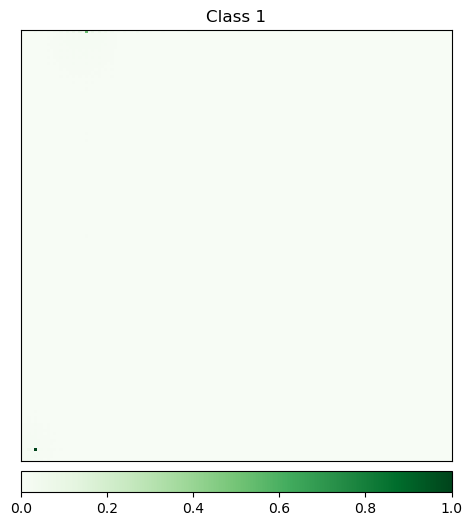

1


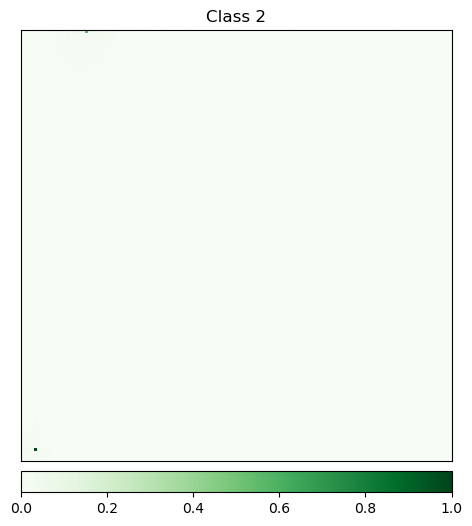

In [24]:
for ndx,mat in enumerate(sums):
#    ax = np.flip(ax_array.flatten())[ndx]
    print(ndx)
    viz.visualize_image_attr(mat,None,
                                 title=class_names[ndx],
                                 method='heat_map',
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1)



In [27]:
impdict={}
for imp in imps:
    for key,items in imp.items():
        itmlist=list(zip(items[0],items[1]))
        if key in impdict:
            impdict[key]=impdict[key]+itmlist
        else:
            impdict[key]=itmlist
            
#    impsorted=sorted(sum(implist,[]),key=lambda a: a[1])
for key,item in impdict.items():
    print(key, len(item))

0 200
1 200


In [28]:
#collect the same

def prep_dict(fromimp):
    res={}
    for k,v in fromimp:
        if k in res:
            res[k].append(v)
        else:
            res[k]=[v]
    return res
    

In [29]:
len(impdict[0])

200

In [50]:
def calculate_ranks_for(analysis):
    res=prep_dict(analysis)
    rank=[[key,len(vals),sum(vals)/len(vals)] for key,vals in res.items()]
    rankneg = [elm for elm in rank if elm[2]<0]
    rankpos = [elm for elm in rank if elm[2]>=0]
    rankneg = sorted(rankneg, key = lambda x: (x[1]*abs(x[2])),reverse=True)
    rankpos = sorted(rankpos, key = lambda x: (x[1]*x[2]),reverse=True)
    return (rankpos, rankneg)

In [51]:

def sort_ranks(impdict, min_occurance = 1):
    ranks={}
    for key,val in impdict.items():
        rankpos,rankneg = calculate_ranks_for(impdict[key])
        print('Pos', rankpos)
        print('Neg', rankneg)
        rankpos = [[feature_names[rank[0]]]+rank  for rank in rankpos if rank[1]>=min_occurance]
        rankneg = [[feature_names[rank[0]]]+rank for rank in rankneg if rank[1]>=min_occurance]
        ranks[key] = (rankpos,rankneg)
        print('Ranks for ',class_names[key], ' ',key)
        print('    Positive rank')
        for elm in rankpos:
            print('    ',elm[0],elm[1], elm[2]+elm[3])
        print('    --------------------------------------------------------------')
        print('    Negative rank')
        for elm in rankneg:
            print('    ',elm[0],elm[1], -1*elm[2]+abs(elm[3]))
    return(ranks)

In [52]:
ranks = sort_ranks(impdict, min_occurance = 0)

Pos [[17689, 5, 76.48202705383301], [20, 10, 20.291581249237062], [18, 10, 2.708795440196991], [22, 10, 2.4923353791236877], [16, 9, 2.278327306111654], [24, 8, 2.141880303621292], [17687, 5, 3.0361337184906008], [14, 8, 1.5495208501815796], [17959, 5, 1.9461926698684693], [26, 6, 1.3964998920758565], [28, 7, 1.120648809841701], [17690, 5, 1.5031635284423828], [12, 6, 1.172024428844452], [17958, 4, 1.50170037150383], [18090, 4, 1.4465488344430923], [17688, 4, 1.4393816590309143], [17823, 4, 1.4056805223226547], [290, 6, 0.8306359847386678], [17419, 3, 1.6254158020019531], [17820, 3, 1.3808672428131104], [17957, 2, 1.8592318892478943], [18092, 2, 1.8478804230690002], [17825, 2, 1.699654459953308], [36, 4, 0.8103457540273666], [288, 5, 0.6465962886810303], [560, 5, 0.6458450078964233], [17685, 2, 1.6035335063934326], [18091, 2, 1.502441644668579], [17821, 2, 1.4256399869918823], [17955, 2, 1.307944118976593], [17691, 2, 1.1952587366104126], [17960, 1, 2.1303951740264893], [286, 3, 0.6953

In [53]:
def visualize_importances(rank, title="Average Feature Importances",axis_title="Features", sign=1):
    print(title)
    feat_names = [elm[0] for elm in rank]
    importances = [elm[2]+abs(elm[3]) * sign for elm in rank] 
    x_pos = (np.arange(len(rank)))
    plt.figure(figsize=(12,6))
    plt.bar(x_pos, importances, align='center')
    plt.xticks(x_pos, feat_names,  rotation=90)
    plt.xlabel(axis_title)
    plt.title(title)

Ranks for  Class 1
Feature Importances for Class 1 positive signals
Ranks for  Class 2
Feature Importances for Class 2 positive signals


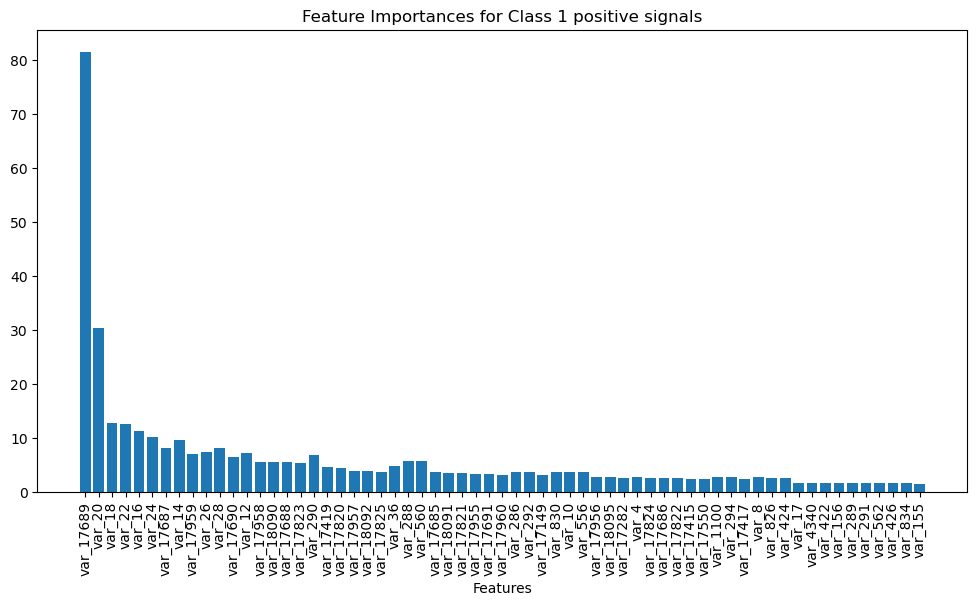

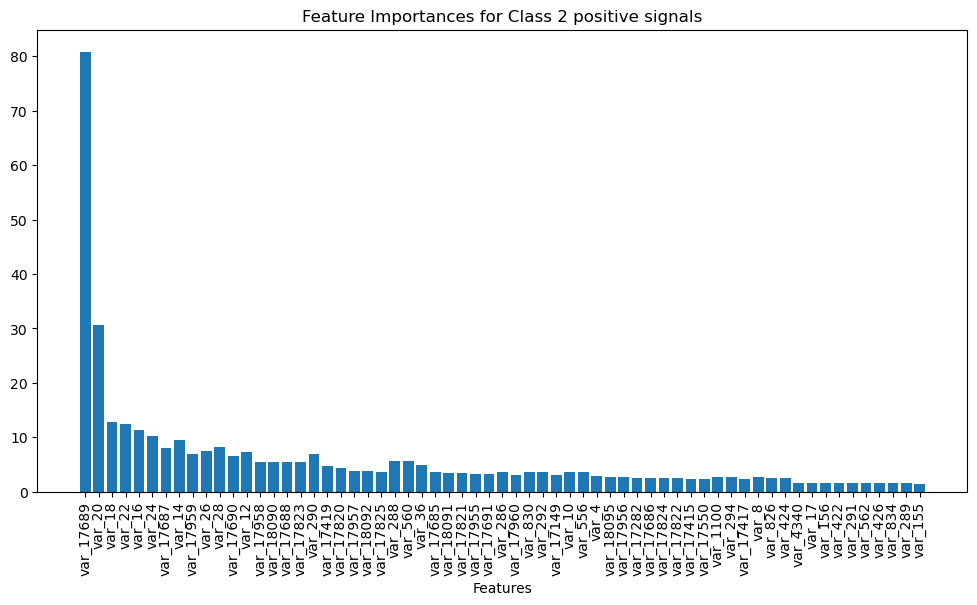

In [55]:
for key,rank in ranks.items():
    print('Ranks for ', class_names[key])
    visualize_importances(rank[0], title="Feature Importances for "+ class_names[key]+ " positive signals")
    if len(rank[1])>0:
        visualize_importances(rank[1], title="Feature Importances for "+ class_names[key]+ " negative signals", sign=-1)

In [ ]:
rankarray=[]
for key,rank in ranks.items():
    for line in rank[0]:
        print(class_names[key],',', line[0], ',', line[2]+line[3],', POSITIVE')
        rankarray.append([class_names[key], line[0], line[1], line[2],line[3]])
    for line in rank[1]:
        print(class_names[key],',', line[0], ',', -1*(line[2]+line[3]),', NEGATIVE')
        rankarray.append([class_names[key], line[0], -1*line[1], line[2],line[3]])
rankarray

In [ ]:
ranksdf=pd.DataFrame(rankarray, columns=['CLASS','FEATURE NAME', 'FEATURE INDEX', 'MAJOR RANK', 'MINOR RANK'])
ranksdf.to_csv('pocdata-ranks.csv', index=False)
ranksdf